In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 [==============================] - 11s 0us/step


In [3]:
img_count = len(list(data_dir.glob('*/*.jpg')))
print(img_count)

3670


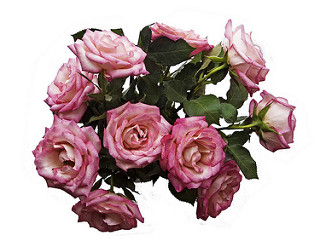

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

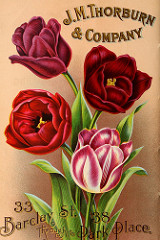

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
cl_names = train_ds.class_names
print(cl_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


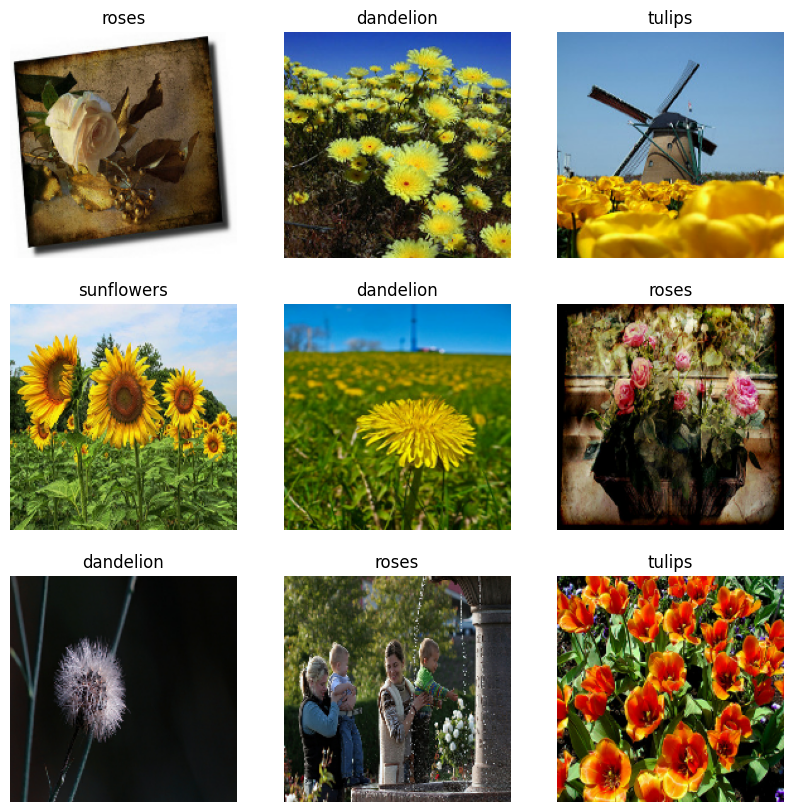

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(cl_names[labels[i]])
    plt.axis('off')

In [11]:
normalization = layers.Rescaling(1./255)

In [12]:
normalized_ds = train_ds.map(lambda x, y: (normalization(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [13]:
num_classes = len(cl_names)

model = Sequential([
    normalization,
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [14]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [15]:
normalized_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
92/92 [==============================] - 20s 65ms/step - loss: 1.3703 - accuracy: 0.4319 - val_loss: 1.1472 - val_accuracy: 0.5477
Epoch 2/10
92/92 [==============================] - 7s 71ms/step - loss: 1.0388 - accuracy: 0.5899 - val_loss: 1.0031 - val_accuracy: 0.6131
Epoch 3/10
92/92 [==============================] - 7s 71ms/step - loss: 0.8304 - accuracy: 0.6853 - val_loss: 0.9604 - val_accuracy: 0.6226
Epoch 4/10
92/92 [==============================] - 6s 62ms/step - loss: 0.6123 - accuracy: 0.7752 - val_loss: 1.1018 - val_accuracy: 0.5926
Epoch 5/10
92/92 [==============================] - 7s 68ms/step - loss: 0.3519 - accuracy: 0.8757 - val_loss: 1.3081 - val_accuracy: 0.6090
Epoch 6/10
92/92 [==============================] - 8s 83ms/step - loss: 0.2105 - accuracy: 0.9319 - val_loss: 1.5060 - val_accuracy: 0.6499
Epoch 7/10
92/92 [==============================] - 6s 63ms/step - loss: 0.1401 - accuracy: 0.9550 - val_loss: 1.5675 - val_accuracy: 0.6158
Epoch 8/10
9

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

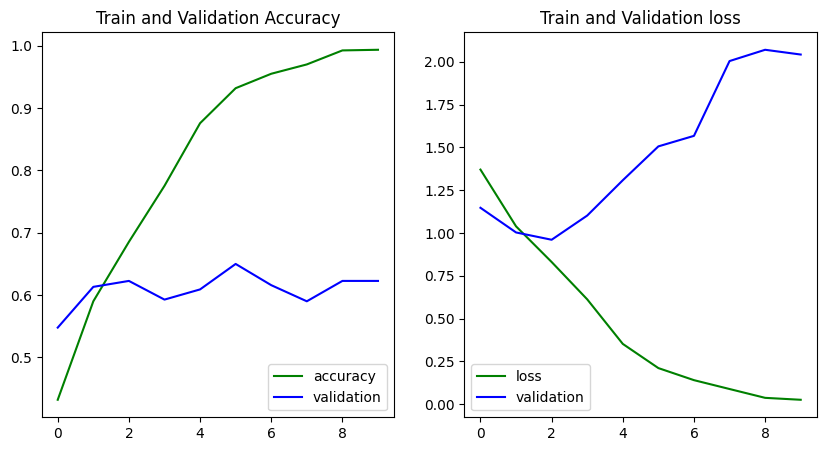

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 10

epoch_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, color='g', label='accuracy')
plt.plot(epoch_range, val_acc, color='b', label='validation')
plt.legend(loc='lower right')
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, color='g', label='loss')
plt.plot(epoch_range, val_loss, color='b', label='validation')
plt.legend(loc='lower left')
plt.title('Train and Validation loss')

plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
    
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

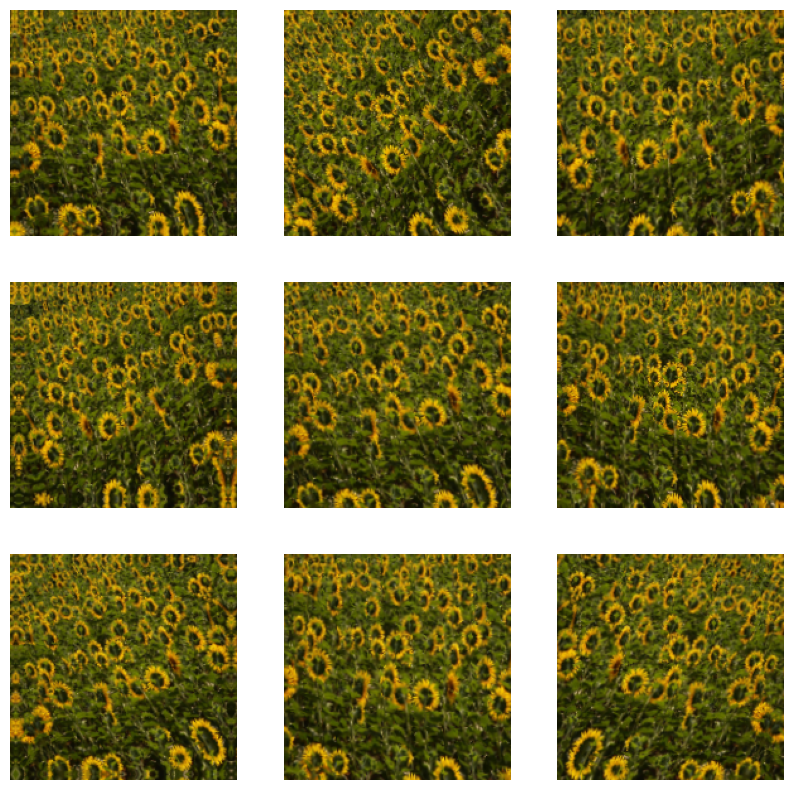

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[20].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
    
    data_augmentation,
    normalization,
    layers.Conv2D(16, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')
])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_ds, epochs=15, validation_data = val_ds)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = 15

epoch_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, color='g', label='accuracy')
plt.plot(epoch_range, val_acc, color='b', label='validation')
plt.legend(loc='lower right')
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, color='g', label='loss')
plt.plot(epoch_range, val_loss, color='b', label='validation')
plt.legend(loc='lower left')
plt.title('Train and Validation loss')

plt.show()

In [ ]:
model_2 = Sequential([
    
    data_augmentation,
    normalization,
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')

  
    ])

In [ ]:
model_2.summary()

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model_2.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
history_2 = model_2.fit(train_ds, epochs=20, validation_data = val_ds, callbacks=[callback])

In [ ]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = 20

epoch_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, acc, color='g', label='accuracy')
plt.plot(epoch_range, val_acc, color='b', label='validation')
plt.legend(loc='lower right')
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_range, loss, color='g', label='loss')
plt.plot(epoch_range, val_loss, color='b', label='validation')
plt.legend(loc='lower left')
plt.title('Train and Validation loss')

plt.show()

In [ ]:
# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    '/content/SD_FD_F44A_29140183_NC_X_EC_90.webp', target_size=(img_height, img_width)
)
# from keras.preprocessing import image

# test_image = image.load_img('/content/single-red-rose.jpg', target_size=(img_height, img_width))
# test_image = image.img_to_array(test_image)

# img_2 = "/content/single-red-rose.jpg"

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

prediction = model_2.predict(img_array)
score = tf.nn.softmax(prediction[0])


print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(cl_names[np.argmax(score)], 100 * np.max(score))
)
